In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
df = pd.read_csv('data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
df = df.set_index(['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, '# Air Passengers')

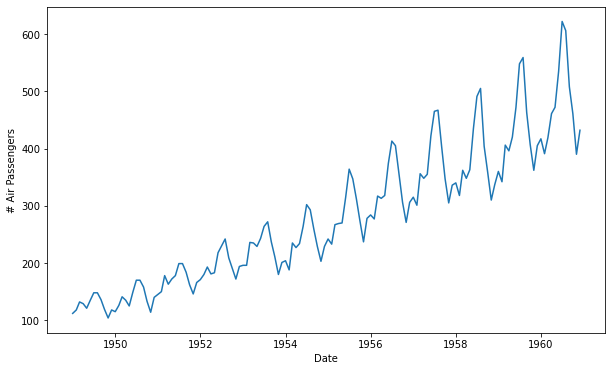

In [5]:
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('# Air Passengers')

### Checking Stationarity

#### Rolling Statistics 

In [6]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
print("Rolling Mean: ", rolling_mean)
print("Rolling Standard deviation: ", rolling_std)

Rolling Mean:              #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]
Rolling Standard deviation:              #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


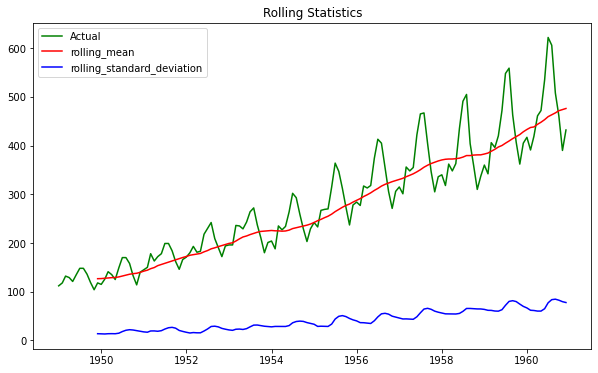

In [7]:
plt.plot(df, color='green', label='Actual')
plt.plot(rolling_mean, color='red', label='rolling_mean')
plt.plot(rolling_std, color='blue', label='rolling_standard_deviation')
plt.legend(loc='best')
plt.title('Rolling Statistics')
plt.show()

#### Observations:
- Rolling standard degviation is constant with time.
- But, Rolling mean has a upward trend component.
- So, the mean is not constant with time
- Hence, we can conclude that the time series is not stationary!

#### Augmented Dickey-Fuller test (ADF test)

In [8]:
adftest = adfuller(df['#Passengers'], autolag='AIC')
adfresult = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
for key, value in adftest[4].items():
    adfresult['Critical Value (%s)'%key] = value
    
print("ADF test results: ")
print(adfresult)

ADF test results: 
Test Statistic            0.815369
p-value                   0.991880
#Lags used               13.000000
#Observations used      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


#### Observations
- p=value > 0.05
- critical values are no where close to test statistic!
- Hence, time series is not stationary!

### Achieving Stationarity

#### Log Scale Transformation

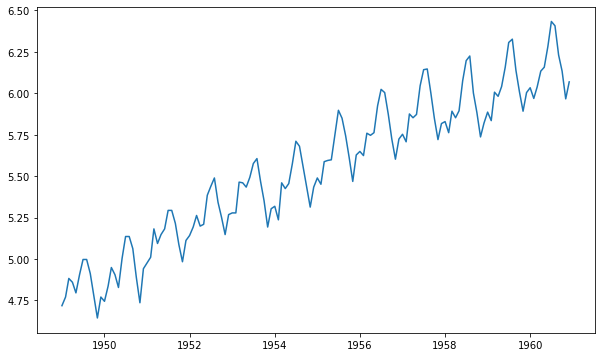

In [9]:
df_log = np.log(df)
plt.plot(df_log)

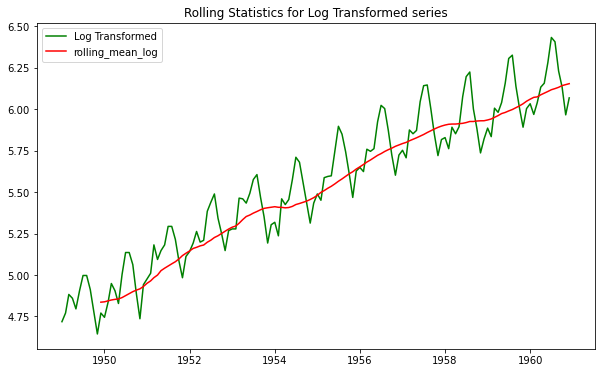

In [10]:
rolling_mean_log = df_log.rolling(window=12).mean()
rolling_std_log = df_log.rolling(window=12).std()
plt.plot(df_log, color='green', label='Log Transformed')
plt.plot(rolling_mean_log, color='red', label='rolling_mean_log')
#plt.plot(rolling_std_log, color='blue', label='rolling_standard_deviation_log')
plt.legend(loc='best')
plt.title('Rolling Statistics for Log Transformed series')
plt.show()

- Subtracting moving average of log transfored series from log scaled transformation results in stationay series!

In [11]:
df_logStationary = df_log - rolling_mean_log
df_logStationary.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [12]:
df_logStationary.dropna(inplace=True)
df_logStationary.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


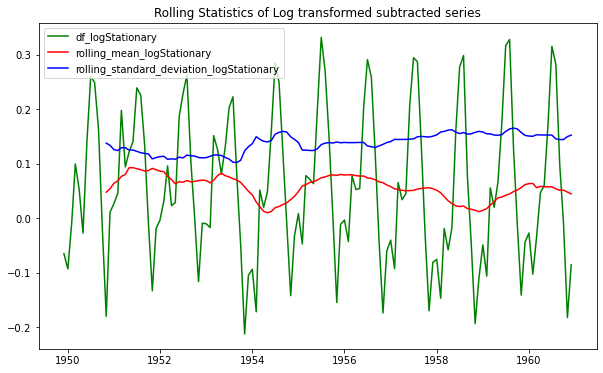

In [13]:
rolling_mean_logStationary = df_logStationary.rolling(window=12).mean()
rolling_std_logStationary = df_logStationary.rolling(window=12).std()
plt.plot(df_logStationary, color='green', label='df_logStationary')
plt.plot(rolling_mean_logStationary, color='red', label='rolling_mean_logStationary')
plt.plot(rolling_std_logStationary, color='blue', label='rolling_standard_deviation_logStationary')
plt.legend(loc='best')
plt.title('Rolling Statistics of Log transformed subtracted series')
plt.show()

In [14]:
adftest = adfuller(df_logStationary['#Passengers'], autolag='AIC')
adfresult = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
for key, value in adftest[4].items():
    adfresult['Critical Value (%s)'%key] = value
    
print("ADF test results: ")
print(adfresult)

ADF test results: 
Test Statistic           -3.162908
p-value                   0.022235
#Lags used               13.000000
#Observations used      119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


- p-value is 0.022 (< 0.05)
- Time series is now Stationary!

#### Exponential Decay Transformation

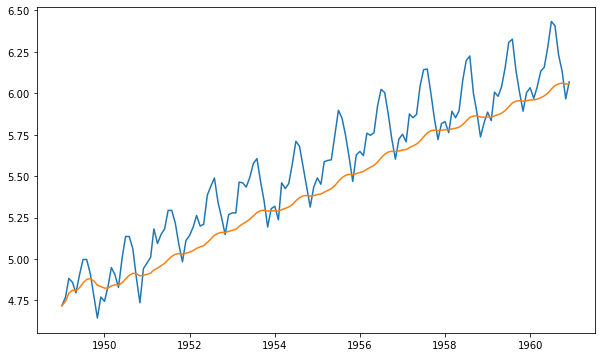

In [15]:
rolling_mean_ed = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(rolling_mean_ed)

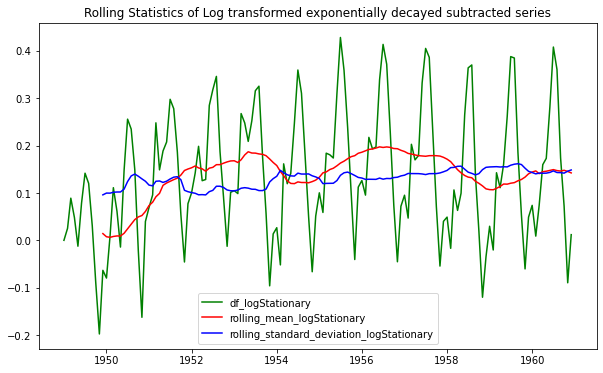

In [16]:
df_edStationary = df_log - rolling_mean_ed

rolling_mean_edStationary = df_edStationary.rolling(window=12).mean()
rolling_std_edStationary = df_edStationary.rolling(window=12).std()
plt.plot(df_edStationary, color='green', label='df_logStationary')
plt.plot(rolling_mean_edStationary, color='red', label='rolling_mean_logStationary')
plt.plot(rolling_std_edStationary, color='blue', label='rolling_standard_deviation_logStationary')
plt.legend(loc='best')
plt.title('Rolling Statistics of Log transformed exponentially decayed subtracted series')
plt.show()

In [17]:
adftest = adfuller(df_edStationary['#Passengers'], autolag='AIC')
adfresult = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
for key, value in adftest[4].items():
    adfresult['Critical Value (%s)'%key] = value
    
print("ADF test results: ")
print(adfresult)

ADF test results: 
Test Statistic           -3.601262
p-value                   0.005737
#Lags used               13.000000
#Observations used      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


#### Observations:
- p-value is 0.005 (much betetr than log transformed series)
- critical values are also much closer to test statistics
- Exponential decay transformation is better than Log transformation!

#### Time Shift Transformation

In [18]:
df_logShift = df_log - df_log.shift()
df_logShift.dropna(inplace=True)

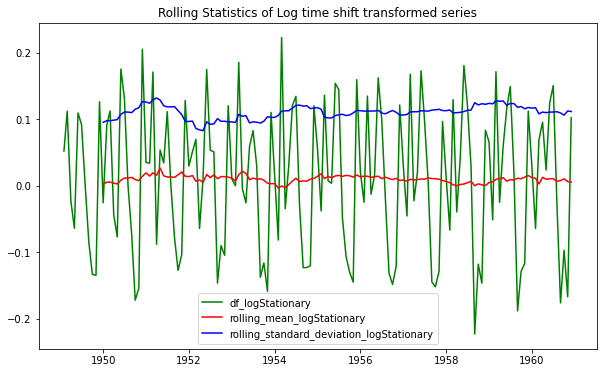

In [19]:
rolling_mean_logShift = df_logShift.rolling(window=12).mean()
rolling_std_logShift = df_logShift.rolling(window=12).std()
plt.plot(df_logShift, color='green', label='df_logStationary')
plt.plot(rolling_mean_logShift, color='red', label='rolling_mean_logStationary')
plt.plot(rolling_std_logShift, color='blue', label='rolling_standard_deviation_logStationary')
plt.legend(loc='best')
plt.title('Rolling Statistics of Log time shift transformed series')
plt.show()

In [20]:
adftest = adfuller(df_logShift['#Passengers'], autolag='AIC')
adfresult = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
for key, value in adftest[4].items():
    adfresult['Critical Value (%s)'%key] = value
    
print("ADF test results: ")
print(adfresult)

ADF test results: 
Test Statistic           -2.717131
p-value                   0.071121
#Lags used               14.000000
#Observations used      128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


#### Observations:
- p-value is 0.07
- exponential decay transformation is better than other transformations!

### Decomposition

<ipython-input-21-b36363043a43>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411)
<ipython-input-21-b36363043a43>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411)


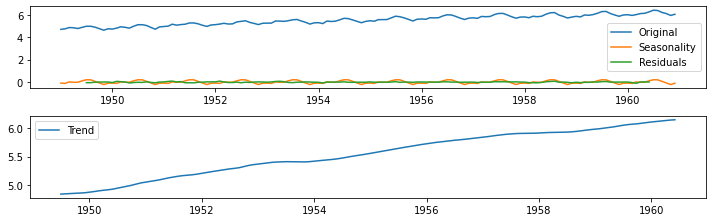

In [21]:
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

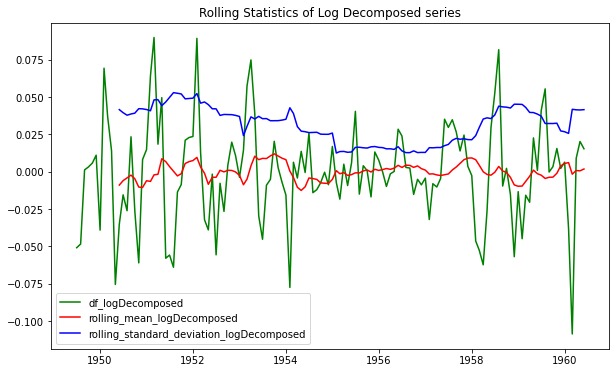

In [22]:
df_logDecomposed = residual
df_logDecomposed.dropna(inplace=True)

rolling_mean_logDecomposed = df_logDecomposed.rolling(window=12).mean()
rolling_std_logDecomposed = df_logDecomposed.rolling(window=12).std()
plt.plot(df_logDecomposed, color='green', label='df_logDecomposed')
plt.plot(rolling_mean_logDecomposed, color='red', label='rolling_mean_logDecomposed')
plt.plot(rolling_std_logDecomposed, color='blue', label='rolling_standard_deviation_logDecomposed')
plt.legend(loc='best')
plt.title('Rolling Statistics of Log Decomposed series')
plt.show()

In [23]:
adftest = adfuller(df_logDecomposed.values, autolag='AIC')
adfresult = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
for key, value in adftest[4].items():
    adfresult['Critical Value (%s)'%key] = value
    
print("ADF test results: ")
print(adfresult)

ADF test results: 
Test Statistic         -6.332387e+00
p-value                 2.885059e-08
#Lags used              9.000000e+00
#Observations used      1.220000e+02
Critical Value (1%)    -3.485122e+00
Critical Value (5%)    -2.885538e+00
Critical Value (10%)   -2.579569e+00
dtype: float64


### Conclusion

- The final transformed dataset to consider would be Exponential Decay transformed Series!

In [24]:
df_edStationary.head()

,#Passengers
Month,
1949-01-01,0.000000
1949-02-01,0.025339
1949-03-01,0.088967
1949-04-01,0.048028
1949-05-01,-0.012415


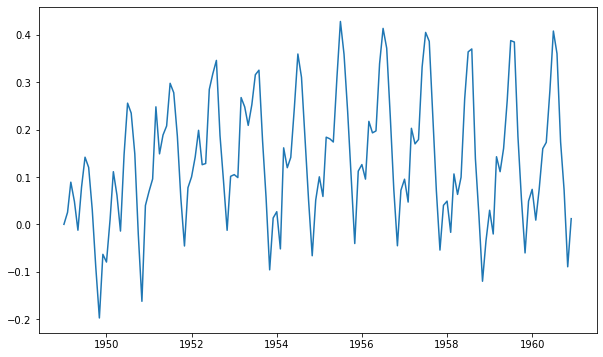

In [25]:
plt.plot(df_edStationary)

In [26]:
df_edStationary.to_csv("transformedData/df_edTransform.csv")

In [27]:
df_logShift.to_csv("transformedData/df_logShift.csv")

In [28]:
df_logStationary.to_csv("transformedData/df_logStationary.csv")